# CartPole (Inverse Pendulum)
We approach our first nonlinear system! I'm not sure if continuous CartPole admits a linearizing (with unlifted controls) and simplifying representation, but we shall see what our methods can do. One topic of interest will be to see whether we can break the symmetry of MSE costs by using time-delayed observations.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import Gym

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter
from extravaganza.utils import jkey, sample, SAMPLING_METHOD

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpm60xq64j
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpm60xq64j/_remote_module_non_scriptable.py


In [2]:
def run(observable, T0: int, reset_every: int, sysid_args):
    """
    fn to gather data and train a sysid.
    """
    # make system
    system = Gym(env_name='CartPoleContinuous-v1', repeat=3, max_episode_len=600)

    # make sysid
    sysid = Lifter(**sysid_args)
    system.reset_hook = lambda : sysid.end_trajectory()

    # interaction loop
    control = jnp.zeros(du)

    traj = Trajectory()
    for t in tqdm.trange(T0):
        if t % reset_every == 0: 
            system.reset()
            traj = Trajectory()
        cost, state = system.interact(control)
        traj.add_state(cost, state)
        obs = observable(traj)
        control = sysid.explore(cost, obs)
        traj.add_control(control)
        
    sysid.end_exploration(wordy=True)
    return system, sysid

In [3]:
def generate(observable, system, sysid, 
             N=1000, reset_every=10, hh=1, use_pbar=True):
    ds, du = system.state_dim, system.control_dim
    do, dl = sysid.obs_dim, sysid.state_dim
    
    states = []
    controls = []
    observations = []
    embeddings = []
    cost, obs, control = 0., jnp.zeros(do), jnp.zeros(du)
    if use_pbar: pbar = tqdm.tqdm(total=N)
    while len(embeddings) < N:
        if len(embeddings) % reset_every == 0:
            system.reset()
            traj = Trajectory()
        cost, state = system.interact(control)  # state will be `None` for unobservable systems
        traj.add_state(cost, state)
        obs = observable(traj)
        emb = sysid.get_state(obs, cost)
        control = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
        traj.add_control(control)
        
        states.append(state)
        controls.append(control)
        observations.append(obs)
        embeddings.append(emb)
        if use_pbar: pbar.update(1)
    if use_pbar: pbar.close()
        
    states, controls, observations, embeddings = map(lambda arr: jnp.stack(arr, axis=0), (states, controls, observations, embeddings))
    states, controls, observations, embeddings = states.reshape(N, ds), controls.reshape(N, du), observations.reshape(N, do), embeddings.reshape(N, dl)
    return states, controls, observations, embeddings

In [4]:
def print_prediction(observable, system, sysid, 
                     k=1, sampling_method='ball', hh=1):
    """
    See some prediction instances
    Here, 'original' means (f \circ g)(x_t), 'gt' means (f \circ g)(x_{t+k}), and 
        'pred' is the predicted embedding at t+k using linear dynamics given by (Ahat, Bhat).
    All norms are in the embedding space
    """
    Ahat, Bhat = sysid.A, sysid.B
    
    system.reset()
    done = False
    
    while not done:
        done = True
        
        traj = Trajectory()
        for _ in range(hh):
            u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
            traj.add_control(u)
            cost, x = system.interact(u)
            traj.add_state(cost, x)
            if system.done: done = False

        s = sysid.get_state(observable(traj), cost)
        original = s.copy()
        for _ in range(k):
            u = sysid.explorer.exploration_scales * sample(jkey(), (du,), sampling_method=SAMPLING_METHOD)
            traj.add_control(u)
            cost, x = system.interact(u)
            traj.add_state(cost, x)
            s = Ahat @ s + Bhat @ u
            if system.done: done = False
        
    gt = sysid.get_state(observable(traj), cost)
    pred = s.copy()
    print(f'||gt - original||={jnp.linalg.norm(gt - original)}\t||pred - original||={jnp.linalg.norm(pred - original)}\t||gt - pred||={jnp.linalg.norm(gt - pred)}')
    pass

In [5]:
def plot(observable, system, sysid, 
         state_idx=2, obs_idx=2,
         N=2000, reset_every=10, hh=1):

    xs, us, os, zs = generate(observable, system, sysid, N=N, reset_every=reset_every, hh=hh)

    dl = zs.shape[1]
    fig, ax = plt.subplots(nrows=dl, ncols=2, figsize=(12, dl * 5))
    ax = ax.reshape(dl, 2)
    _xs, _os = xs[:, state_idx], os[:, obs_idx]
    for i in range(dl):
        _zs = zs[:, i]
        ax[i, 0].scatter(_xs, _os, color='r', label='obs(x)')
        ax[i, 0].scatter(_xs, _zs, s=4, color='b', label='emb(x)')
        ax[i, 1].scatter(_zs, _xs, color='c', label='x(emb)')
        ax[i, 1].scatter(_zs, _os, s=4, color='purple', label='obs(emb)')

        ax[i, 0].set_title('state space')
        ax[i, 0].set_xlabel('state')
        ax[i, 1].set_xlabel('emb_{}'.format(i))
        ax[i, 1].set_title('{}th coord of embedding space'.format(i))
        ax[i, 0].legend(); ax[i, 1].legend()
    plt.show()
    pass

# (1) Full Observation

In [6]:
# # dimensions
# ds, du = 4, 1
# dl = 1

# # define observation fn
# # observable = FullObservation(state_dim=ds)
# do = 1
# observable = Observable(obs_dim=do, obs_func=lambda traj: traj.x[-1][2:3])

# # send it
# T0 = 5000
# reset_every = int(1e9)
# exploration_args = {'scales': 0.5, 'avg_len': 5}
# sysid_args = {
#     'obs_dim': do,
#     'control_dim': du,
#     'state_dim': dl,

#     'exploration_args': {'random 0.8': exploration_args,
#                          'impulse 0.2': exploration_args,
#                         },

#     'method': 'nn',
#     'AB_method': 'regression',
#     'deterministic': True,
#     'isometric': False,

#     'sigma': 0,
#     'depth': 3,
#     'num_iters': 12000,
#     'batch_size': 256,
#     'lifter_lr': 0.001,
    
#     'hh': 2,
# }
# system, sysid = run(observable, T0, reset_every, sysid_args)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
INFO: (EXPLORER) generating exploration control sequences using ['random', 'impulse'] w.p. [0.8 0.2]
5003it [00:01, 2844.87it/s]                                                            

regression (ret) :
||A||_op = 0.6996811628341675
||B||_F = 0.03930595889687538
||A-BK||_op = 0.6975759267807007
eig(A) = [0.69968116]
svd(B) = [0.03930596]

moments :
||A||_op = 0.7759835720062256
||B||_F = 0.00540213193744421
||A-BK||_op = 0.7759266495704651
eig(A) = [0.7759836]
svd(B) = [0.00540213]



In [7]:
# # check things
# if 'learned' in sysid.AB: sysid.A, sysid.B = sysid.AB['regression']
# print('\npredictions:')
# for _ in range(5):
#     print_prediction(observable, system, sysid, k=5, hh=3)


predictions:
||gt - original||=0.2502554655075073	||pred - original||=0.1512688547372818	||gt - pred||=0.09898660331964493
||gt - original||=0.22865958511829376	||pred - original||=0.10344264656305313	||gt - pred||=0.12521693110466003
||gt - original||=0.04208541661500931	||pred - original||=0.05650116875767708	||gt - pred||=0.09858658909797668
||gt - original||=0.20272991061210632	||pred - original||=0.1265350729227066	||gt - pred||=0.07619484513998032
||gt - original||=0.24858173727989197	||pred - original||=0.11596761643886566	||gt - pred||=0.1326141059398651


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1877.54it/s]


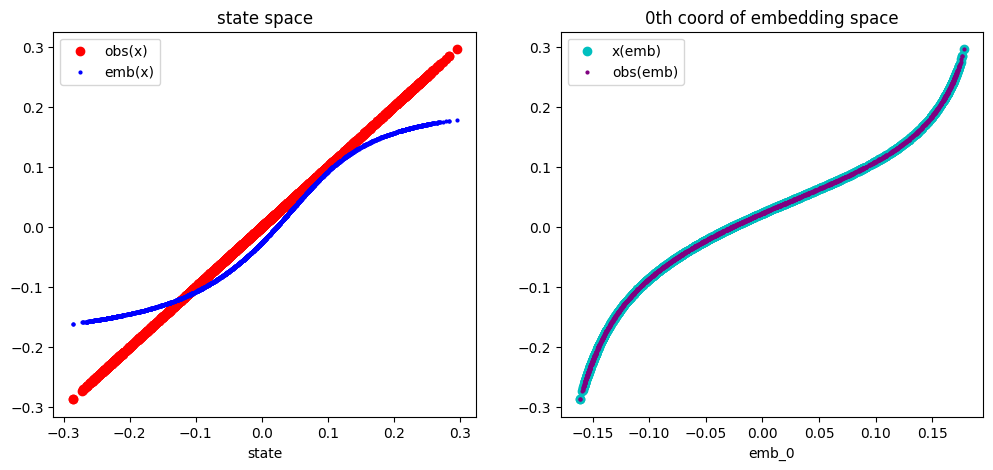

In [8]:
# plot(observable, system, sysid, N=2000, reset_every=reset_every, hh=3,
#     state_idx=2, obs_idx=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1897.21it/s]


Array(-0.01117634, dtype=float32)

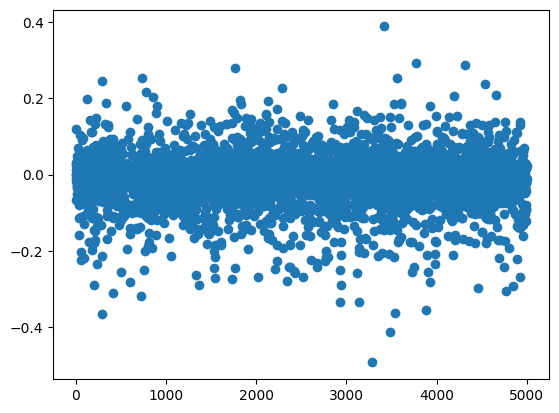

In [9]:
# xs, us, os, zs = generate(observable, system, sysid, N=5000, reset_every=500)
# diffs = os[1:] - os[:-1]
# dots = (diffs * us[:-1]).sum(axis=-1)
# plt.scatter(range(dots.shape[0]), dots)
# dots.mean()

# (2) Time-Delayed Costs & Controls

In [16]:
# dimensions
ds, du = 4, 1
dl = 1

# define observation fn
hh = 3
observable = TimeDelayedObservation(hh=hh, control_dim=du,
                                    use_controls=True, use_costs=True,
                                    use_states=False, use_cost_diffs=False, use_time=False)
do = observable.obs_dim

# send it
T0 = 5000
reset_every = int(1e9)
exploration_args = {'scales': 0.5, 'avg_len': 5}
sysid_args = {
    'obs_dim': do,
    'control_dim': du,
    'state_dim': dl,

    'exploration_args': {'random 0.8': exploration_args,
                         'impulse 0.2': exploration_args,
                        },

    'method': 'nn',
    'AB_method': 'learned',
    'deterministic': True,
    'isometric': False,
    
    'sigma': 0.01,
    'depth': 6,
    'num_iters': 24000,
    'batch_size': 512,
    'lifter_lr': 0.001,
    
    'hh': hh,
}
system, sysid = run(observable, T0, reset_every, sysid_args)

INFO: (EXPLORER) generating exploration control sequences using ['random', 'impulse'] w.p. [0.8 0.2]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3236.29it/s]
INFO: (LIFTER): using "learned" method to get the AB matrices during each training step
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4042.86it/s]
INFO: (LIFTER): ending sysid phase at step 5000
INFO: (LIFTER): NOTE THAT WE ARE USING FMEAN TO RESCALE EMBEDDINGS DURING INFERENCE (so outputs of `get_state()` will have their true norms instead of their normalized ones)!!!
INFO: training!
INFO: mean loss for iters -2400 - 0:
INFO: 		consistency: 	0.1746460497379303
INFO: 		l2 linearization 0: 	1.288801908493042
INFO: 		l2 linearization 1: 	0.953968346118927
INFO: 		l2 linearization 2: 	0.927075982093811
INFO: 		nontrivial: 	1000.0000610351562
INFO: 		sim

regression (ret) :
||A||_op = 0.252358615398407
||B||_F = 0.03012028895318508
||A-BK||_op = 0.25211435556411743
eig(A) = [0.25235862]
svd(B) = [0.03012029]

moments :
||A||_op = 0.3089536726474762
||B||_F = 0.004338308237493038
||A-BK||_op = 0.30894723534584045
eig(A) = [0.30895367]
svd(B) = [0.00433831]

learned :
||A||_op = 0.9144152402877808
||B||_F = 4.942014797393313e-09
||A-BK||_op = 0.9144152402877807
eig(A) = [0.91441524]
svd(B) = [4.942015e-09]



In [17]:
# check things
if 'learned' in sysid.AB: sysid.A, sysid.B = sysid.AB['learned']
print('\npredictions:')
for _ in range(5):
    print_prediction(observable, system, sysid, k=5, hh=3)


predictions:
||gt - original||=0.16802066564559937	||pred - original||=0.0333377979695797	||gt - pred||=0.13468286395072937
||gt - original||=0.03372184932231903	||pred - original||=0.03343737870454788	||gt - pred||=0.0002844706177711487
||gt - original||=0.0003475099802017212	||pred - original||=0.019497845321893692	||gt - pred||=0.019845355302095413
||gt - original||=0.15852825343608856	||pred - original||=0.03845351189374924	||gt - pred||=0.12007474154233932
||gt - original||=0.011312343180179596	||pred - original||=0.02578894793987274	||gt - pred||=0.014476604759693146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1659.62it/s]


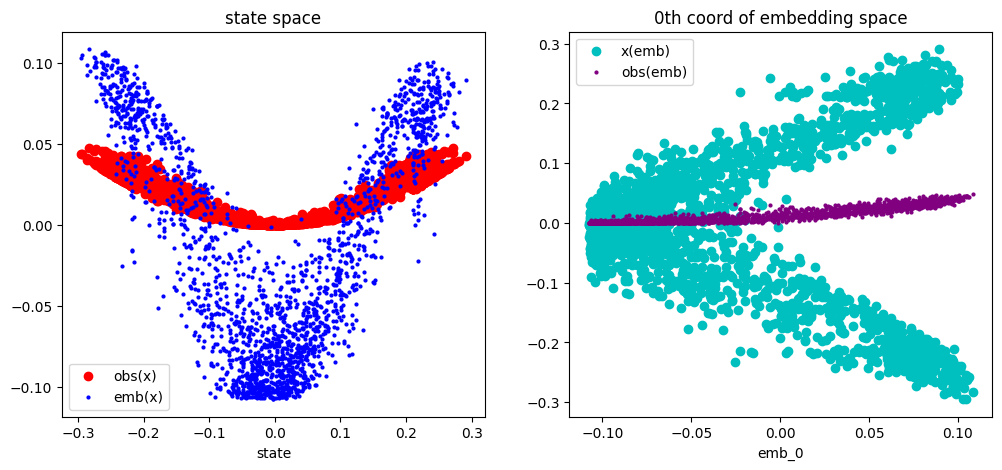

In [18]:
plot(observable, system, sysid, N=2000, reset_every=reset_every, hh=hh,
    state_idx=2, obs_idx=-1)